# Load the dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


def get_datasets(num_epochs, batch_size):
    """Load CIFAR dataset into memory"""

    train_ds: tf.data.Dataset = tfds.load("cifar10", split="train")
    test_ds: tf.data.Dataset = tfds.load("cifar10", split="test")


    train_ds = train_ds.map(
        lambda sample: {
            'image': tf.cast(sample['image'], tf.float32) / 255.,
            'label': sample['label']
        }
    )

    test_ds = test_ds.map(
        lambda sample: {
            'image': tf.cast(sample['image'], tf.float32) / 255.,
            'label': sample['label']
        }
    )

    train_ds = train_ds.repeat().shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).take(num_epochs).prefetch(1)

    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

In [2]:
input_shape = (32,32,3)
num_epochs = 10_000
batch_size = 32

train_ds, test_ds = get_datasets(num_epochs, batch_size)
assert train_ds.take(1).element_spec['image'].shape[1:] == input_shape

# Define the model

In [3]:
import jax
from flax import nnx

import functools
import itertools
from typing import Sequence, Callable


compose = lambda *fs: functools.reduce(lambda f, g: lambda x: g(f(x)), fs)
rolling_window = lambda xs: [xs[i-1:i+1] for i in range(1, len(xs))]



class MLP(nnx.Module):
    """A simple MLP classifier"""

    def __init__(
            self,
            dim_in,
            dim_out,
            *,
            hidden_dims: Sequence[int],
            activation: Callable,
            rngs: nnx.Rngs):

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.hidden_dims = hidden_dims
        self.activation = activation

        self.layers = []
        for di, do in rolling_window([self.dim_in]+self.hidden_dims):
            self.layers.extend([
                nnx.Linear(di, do, rngs=rngs),
                self.activation
            ])
        self.layers.append(
            nnx.Linear(self.hidden_dims[-1], self.dim_out, rngs=rngs)
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        x = x.reshape(x.shape[0], -1)
        return compose(*itertools.chain(self.layers))(x)

In [4]:
import operator

rngs = nnx.Rngs(0)
dim_in = functools.reduce(operator.mul, input_shape)
dim_out = 10
activation = nnx.relu

model = MLP(dim_in, dim_out, hidden_dims=[200, 150], activation=activation, rngs=rngs)
nnx.display(model)

W0000 00:00:1733012746.840290 6655040 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1733012746.851385 6655040 service.cc:145] XLA service 0x14b211060 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733012746.851399 6655040 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1733012746.852787 6655040 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1733012746.852799 6655040 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

MLP(
  dim_in=3072,
  dim_out=10,
  hidden_dims=[200, 150],
  activation=<jax._src.custom_derivatives.custom_jvp object at 0x13efdf770>,
  layers=[Linear(
    kernel=Param(
      value=Array(shape=(3072, 200), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(200,), dtype=float32)
    ),
    in_features=3072,
    out_features=200,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x14baac4a0>,
    bias_init=<function zeros at 0x13ef2e3e0>,
    dot_general=<function dot_general at 0x13e8efe20>
  ), <jax._src.custom_derivatives.custom_jvp object at 0x13efdf770>, Linear(
    kernel=Param(
      value=Array(shape=(200, 150), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(150,), dtype=float32)
    ),
    in_features=200,
    out_features=150,
    use_bias=True,
    dtype=No

# Checking the model

In [5]:
import jax.numpy as jnp

model(jnp.ones([batch_size, *input_shape])).shape

(32, 10)

# Create the optimizer and define some metrics

In [6]:
import optax

learning_rate = 0.0005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adam(learning_rate, momentum))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss")
)
nnx.display(metrics)

MultiMetric(
  accuracy=Accuracy(
    argname='values',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  ),
  loss=Average(
    argname='loss',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  )
)


# Define training steps

In [7]:
def loss_fn(model: MLP, batch):
    logits = model(batch["image"])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch["label"]
    ).mean()
    return loss, logits

In [8]:
@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["label"])
    optimizer.update(grads)

@nnx.jit
def eval_step(model: MLP, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["label"])

# Train and evaluate the model

In [9]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

eval_every = 200

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == num_epochs - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f"train_{metric}"].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(
      f"[train] step: {step}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"[test] step: {step}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

[train] step: 200, loss: 2.091412305831909, accuracy: 22.71455192565918
[test] step: 200, loss: 1.9533394575119019, accuracy: 28.90625
[train] step: 400, loss: 1.9448620080947876, accuracy: 29.859375
[test] step: 400, loss: 1.9155163764953613, accuracy: 31.690704345703125
[train] step: 600, loss: 1.846746802330017, accuracy: 33.78125
[test] step: 600, loss: 1.824628233909607, accuracy: 33.60376739501953
[train] step: 800, loss: 1.8262766599655151, accuracy: 33.6875
[test] step: 800, loss: 1.8833688497543335, accuracy: 32.261619567871094
[train] step: 1000, loss: 1.7782989740371704, accuracy: 36.0
[test] step: 1000, loss: 1.7662601470947266, accuracy: 36.879005432128906
[train] step: 1200, loss: 1.759678602218628, accuracy: 36.515625
[test] step: 1200, loss: 1.7232586145401, accuracy: 38.36137771606445
[train] step: 1400, loss: 1.7347838878631592, accuracy: 38.0625
[test] step: 1400, loss: 1.6957992315292358, accuracy: 39.102561950683594
[train] step: 1600, loss: 1.7187875509262085, acc

# Visualize the metrics

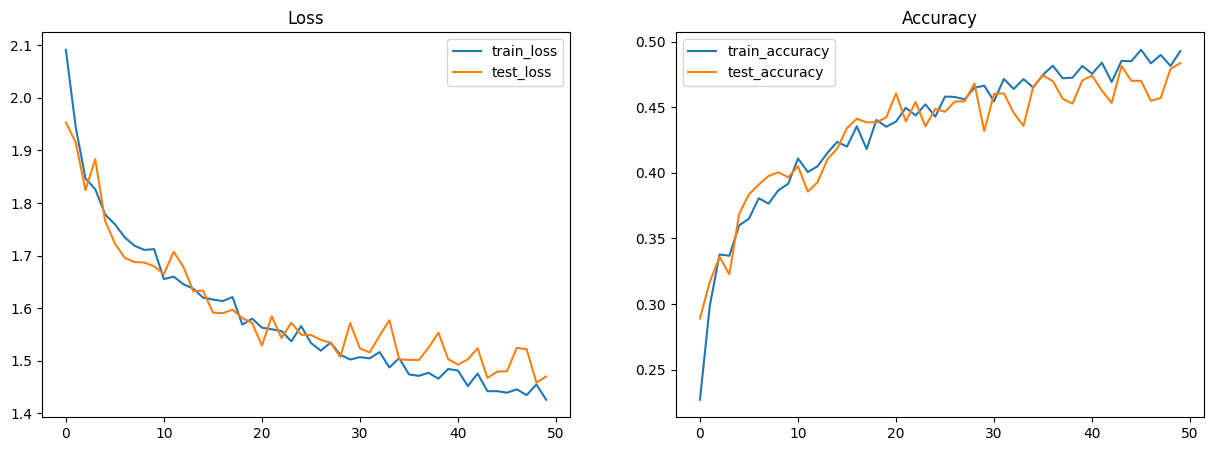

In [10]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

# Perform inference on the test set

In [11]:
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: MLP, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

In [12]:
import numpy as np

CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [13]:
test_batch = test_ds.as_numpy_iterator().next()
pred = CLASSES[pred_step(model, test_batch)]
pred

array(['cat', 'frog', 'airplane', 'cat', 'airplane', 'automobile', 'cat',
       'automobile', 'deer', 'airplane', 'frog', 'frog', 'horse', 'deer',
       'ship', 'horse', 'horse', 'automobile', 'frog', 'horse', 'horse',
       'horse', 'airplane', 'truck', 'cat', 'cat', 'truck', 'horse',
       'airplane', 'automobile', 'dog', 'truck'], dtype='<U10')

In [14]:
#actual = CLASSES[]

actual = CLASSES[test_batch["label"]]
actual

array(['dog', 'frog', 'airplane', 'dog', 'dog', 'automobile', 'truck',
       'automobile', 'cat', 'truck', 'frog', 'deer', 'horse', 'bird',
       'horse', 'horse', 'horse', 'ship', 'frog', 'airplane', 'bird',
       'bird', 'airplane', 'truck', 'cat', 'dog', 'airplane', 'horse',
       'airplane', 'automobile', 'dog', 'airplane'], dtype='<U10')

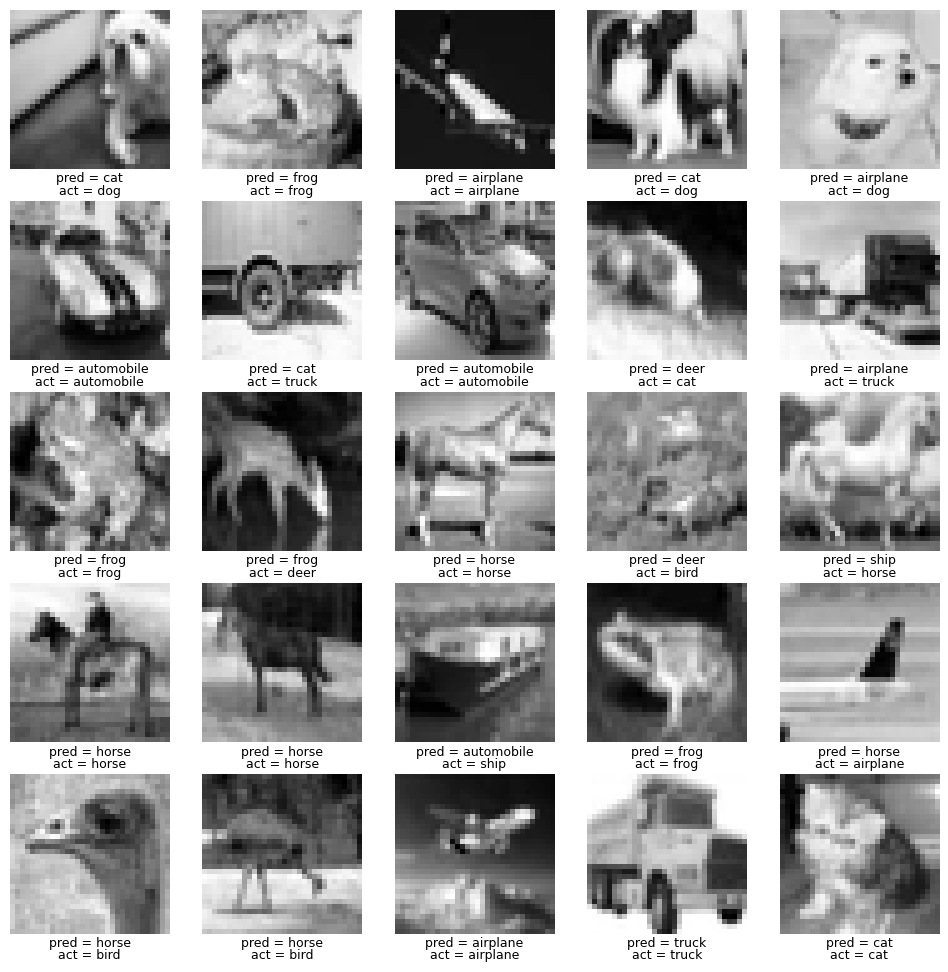

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for idx, ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.text(0.5, -0.08, 'pred = ' + pred[idx], fontsize=9, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.16, 'act = ' + actual[idx], fontsize=9, ha='center', transform=ax.transAxes)
    ax.imshow(test_batch['image'][idx, ..., 0], cmap='gray')
    ax.axis('off')